In [1]:
# Python 3
# Required libraries
from datetime import timedelta
from dateutil import parser
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import re

warnings.filterwarnings("ignore")

In [2]:
# Import csv file:
data = pd.read_csv(r'Data/code_languages.csv')

## Cleaning data

In [3]:
# Extract tool name from title:
# Names of tools:
tools = ['SQL', 'MySQL','Excel','Tableau', 'Azure', 'AWS','R']
pat = '|'.join(r"\b{}\b".format(x) for x in tools)

data['tool'] = data['title'].str.extract('('+ pat + ')', expand=False, flags=re.I)

# Extract the age of  video; time past since video was posted:
data['duration_from_posted'] = data.published_date.str.extract('(\d+)')


# Length of the video in seconds
data['length'] = data['length'].str.strip()
data['length'] = pd.to_datetime(data['length'],format='%H:%M:%S',errors='coerce').fillna(pd.to_datetime(data['length'], format='%M:%S', errors='coerce'))

time = pd.to_datetime('1900-01-01 00:00:00', format =  "%Y-%m-%d %H:%M:%S")
time_delta = (data['length']  - time).astype('timedelta64[s]')
data['length'] = time_delta

# Replace NA in channel.verified assuming missing means False
data[ 'channel.verified'] = data[ 'channel.verified'].replace(np.nan, "False")

## Required data

In [4]:
# Required data:
cols = ['tool', 'duration_from_posted', 'length', 'channel.verified', 'views']
req_data = data[cols]

<AxesSubplot:>

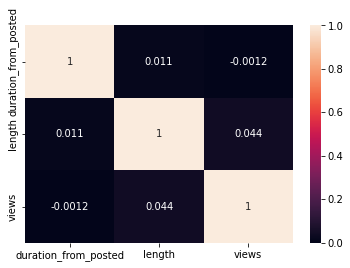

In [5]:
# Correlation heatmap
num_data = req_data[['duration_from_posted', 'length', 'views']]
cols = ['duration_from_posted', 'views', 'length']

# Convert all columns to numeric
num_data[cols] = num_data[cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

# Drop all missing values
num_data = num_data.dropna()

# View heatmap
sns.heatmap(num_data.corr(),  annot=True)

## Data Training & Regression Model

In [6]:
# Divide data into attributes and labels
X = num_data.iloc[:, 0:2].values
y = num_data.iloc[:, 2].values #Views

# Divide the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Training a linear regression model
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Build model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# #  Apply trained model to predict logS from the training and test set
y_pred_train = model.predict(X_train)


print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_train, y_pred_train))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_train, y_pred_train))

Coefficients: [2.24447488e+03 1.43589143e+00]
Intercept: 1131596.7122364428
Mean squared error (MSE): 5304923880052.27
Coefficient of determination (R^2): 0.00


In [7]:
#  apply the trained model to make predictions on the test set
y_pred_test = model.predict(X_test)

# Evaluation
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(y_test, y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(y_test, y_pred_test))

Coefficients: [2.24447488e+03 1.43589143e+00]
Intercept: 1131596.7122364428
Mean squared error (MSE): 1293437693516.65
Coefficient of determination (R^2): -0.20


In [8]:
# Regression equation
yintercept = '%.2f' % model.intercept_
dp = '%.2f dp' % model.coef_[0]
lt = '%.4f lt' % model.coef_[1]

print('Views = ', yintercept,  '+', dp, '+', lt )

Views =  1131596.71 + 2244.47 dp + 1.4359 lt


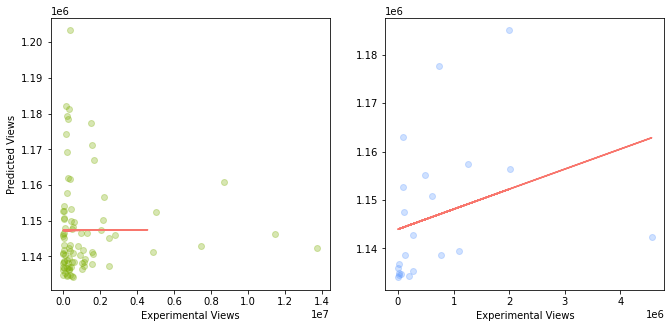

In [42]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(11,5))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=y_train, y=y_pred_train, c="#7CAE00", alpha=0.3)

z = np.polyfit(y_train, y_pred_train, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"#F8766D")

plt.ylabel('Predicted Views')
plt.xlabel('Experimental Views')

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)
plt.scatter(x=y_test, y=y_pred_test, c="#619CFF", alpha=0.3)

z = np.polyfit(y_test, y_pred_test, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"#F8766D")

plt.xlabel('Experimental Views')
plt.show()

# End